In [2]:
# number the equations (TeX/MathJax)
display("text/html", "<script type=\"text/javascript\">MathJax.Hub.Config({ TeX: { equationNumbers: { autoNumber : \"AMS\" }} })</script>")

In [3]:
using Pkg

In [4]:
Pkg.add("NLopt")
Pkg.add("Gadfly")
Pkg.add("Compose")
Pkg.add("QuadGK")
Pkg.add("DataFrames")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %19.3 %                          ]  33.5 % [===================>                     ]  45.9 %1 %>               ]  62.5 %==============================>          ]  74.9 %]  87.1 %Fetching: [=======================================> ]  96.3 % Resolving package versions...
 Installed SoftGlobalScope ───── v1.0.10
 Installed Compat ────────────── v2.1.0
 Installed DocStringExtensions ─ v0.7.0
 Installed TranscodingStreams ── v0.9.3
 Installed Optim ─────────────── v0.18.1
 Installed Distributions ─────── v0.17.0
 Installed Ratios ────────────── v0.3.1
 Installed DiffEqDiffTools ───── v0.8.1
 Installed Juno ──────────────── v0.7.0
 Installed Tables ────────────── v0.1.18
 Installed WeakRefStrings ────── v0.5.8
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environm

In [5]:
using Gadfly
using Compose
set_default_plot_size(12cm, 12cm)

┌ Info: Recompiling stale cache file /Users/tlazauskas/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1187


In [6]:
# an update in place operator
function (←){T}(a::T, b::T)
    for f in fieldnames(a)
        setfield!(a, f, getfield(b, f))
    end
end

UndefVarError: UndefVarError: ← not defined

In [7]:
C = [1.00 0.95;
     0.95 1.00]

2×2 Array{Float64,2}:
 1.0   0.95
 0.95  1.0 

In [8]:
"Pdf of a joint Gaussian distribution in two variables."
function gaussian_pdf(x,y; cov_matrix=C)
    # the \ operator is linear system solve (similar to Matlab).
    return exp(-0.5*LinearAlgebra.dot([x,y],cov_matrix\[x,y])) / (2*pi) * sqrt(LinearAlgebra.det(cov_matrix))
end

gaussian_pdf

In [9]:
import QuadGK: quadgk

In [10]:
"""
    conditional_distr(f :: Function, condition :: Function)

Given a distribution `f`, representing a pdf ``f_{X,Y}(x,y)``, and a 
condition `condition` of the form `y -> (a,y)`, returns a function of
one argument representing ``f_{Y|X=a}(y)``.  Limited to two variables 
due to quadgk.
"""
function conditional_distr(f, condition)
    marginal, error = quadgk(x -> f(condition(x)...), -Inf, Inf)
    return (x -> f(condition(x)...)/marginal)
end

conditional_distr

In [11]:
?conditional_distr

search: conditional_distr



```
conditional_distr(f :: Function, condition :: Function)
```

Given a distribution `f`, representing a pdf $f_{X,Y}(x,y)$, and a  condition `condition` of the form `y -> (a,y)`, returns a function of one argument representing $f_{Y|X=a}(y)$.  Limited to two variables  due to quadgk.


In [12]:
import LinearAlgebra

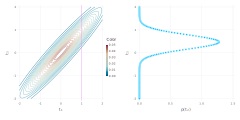

In [15]:
let t1s = range(-2.0, stop=2.0, length=200),
    t2s = range(-2.0, stop=2.0, length=200),
    plot_range = Coord.cartesian(xmin=minimum(t1s),
                                 xmax=maximum(t1s),
                                 ymin=minimum(t2s),
                                 ymax=maximum(t2s)),
    condition_annotation = Guide.annotation(compose(context(), # new empty context for the composed annotation
                                                    line([(1.0,10.0), (1.0,-10.0)]),
                                                    stroke("violet"))),
    contour_levels = Geom.contour(levels=20);
    
    draw(SVGJS(24cm, 12cm),
         hstack(plot(x = t1s,
                     y = t2s,
                     z = [gaussian_pdf(t1,t2) for t1 in t1s, t2 in t2s],
                     plot_range,
                     contour_levels,
                     condition_annotation,
                     Guide.xlabel("t₁"),
                     Guide.ylabel("t₂")),
                plot(x = [conditional_distr(gaussian_pdf, y->(0.5,y))(t1) for t1 in t1s],
                     y = t1s,
                     Guide.xlabel("p(t₂)"),
                     Guide.ylabel("t₂"))))
end

In [43]:
squared_exp(x,y,σ,r) = σ^2 * exp(-sum(0.5*(x-y).^2/r.^2))

squared_exp (generic function with 1 method)

In [45]:
mutable struct GP
    # The covariance function
    cov_kernel :: Function
    # The noise model
    ν          :: Float64
    # The hyperparameters
    θ          :: Vector{Float64}
    # The inputs and observations
    xs         :: Vector
    ts         :: Vector{Float64}
    # Covariance matrix (and its inverse)
    C          :: Matrix{Float64}
    # Inverse of covariance matrix (but see note)
    invC       :: Matrix{Float64}
    # Precomputed C\ts
    invCts     :: Vector{Float64}
end

In [56]:
function GP(cov_kernel, ν, θ, xs=Array{Float64}(0), ts=Array{Float64}(0))
    # compute the covariance matrix
    C = [cov_kernel(x1, x2, θ...) for x1=xs, x2=xs] + LinearAlgebra.diagm(0=>[ν for x=xs])
    # defer to the default constructor
    GP(cov_kernel, ν, θ, xs, ts, C, inv(C), C \ ts)
end

GP

In [62]:
my_gp = GP(squared_exp, 1E-7, [4.0, 20.0], [1.0, 2.0, 3.0], [1.0, 2.0, 3.0])

GP(squared_exp, 1.0e-7, [4.0, 20.0], [1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [16.0 15.98 15.9202; 15.98 16.0 15.98; 15.9202 15.98 16.0], [5003.77 -9982.53 4991.24; -9982.53 19940.2 -9982.53; 4991.24 -9982.53 5003.77], [12.4408, -49.7567, 37.5033])

In [63]:
covar(gp :: GP, x1, x2) = gp.cov_kernel(x1, x2, gp.θ...)


# Julia feature: M' == transpose(M)
function gp_predict(gp :: GP, xnew :: Float64)
    k = [covar(gp, xnew, x) for x = gp.xs]
    kappa = covar(gp, xnew, xnew) + gp.ν
    mean = k' * gp.invCts
    var = kappa - k' * gp.invC * k
    return (mean, var)
end

"""Given a Gaussian process and a vector of input vectors to predict, 
return a tuple consisting of the mean and covariance of the posterior 
distribution at those points"""
function gp_predict(gp :: GP, xnews :: Vector)
    k = [covar(gp, xnew, x) for x = gp.xs, xnew = xnews]
    kappa = [covar(gp, xnew1, xnew2) for xnew1 in xnews, xnew2 in xnews] + diagm([gp.ν for xnew in xnews])
    means = k' * gp.invCts
    vars = kappa - k' * gp.invC * k
    return (means, vars)
end

"Update the hyperparameters in place"
function set_hyperparameters!(gp :: GP, hypers :: Vector{Float64})
    if (gp.ν != hypers[1]) || (gp.θ != hypers[2:end])
        # We defined '←' above: performs the update in place
        gp ← GP(gp.cov_kernel, hypers[1], hypers[2:end], gp.xs, gp.ts)
    end
end

set_hyperparameters!

In [67]:
# Julia features: DataFrames, anonymous functions, random numbers

using DataFrames

let xs = range(0.0, stop=1.0, length=11);
    global synth1 = DataFrame(x = xs, 
                              t = map(x -> x + 0.1*randn(), xs))
end

let xs = range(0.0, stop=1.0, length=21);
    global synth2 = DataFrame(x = xs,
                              t = map(x -> sin(7*x) + 0.5*sin(9*x) + 1.2*sin(11*x), xs))
end

synth3 = DataFrame(x = [1,2,3,4,5], t = [1.2, 2.0, 0.0, 4.0, 5.0])

,x,t
,Int64,Float64
1,1,1.2
2,2,2.0
3,3,0.0
4,4,4.0
5,5,5.0


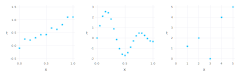

In [68]:
# Julia features: symbols, quoting
draw(SVGJS(24cm, 8cm),
    hstack(plot(synth1, x=:x, y=:t), plot(synth2, x=:x, y=:t), plot(synth3, x=:x, y=:t)))

In [ ]:
# Julia features: convert, ribbon plots from a DataFrame

synth2_gp = GP(squared_exp, 1E-6, [4.0, 0.2], convert(Array, synth2[:x]), convert(Array, synth2[:t]))
begin
    xs = range(0.0,stop=2.0,length=100)
    ts_it, vars_it = zip([gp_predict(synth2_gp, x) for x in xs]...)
    ts = [ts_it...]
    vars = [vars_it...]
    global synth2_fit = DataFrame(
                x = xs,
                t = ts,
                tmin = ts - sqrt.(vars),
                tmax = ts + sqrt.(vars)
           )
end
plot(layer(synth2, x=:x, y=:t, Geom.point),
     layer(synth2_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon))

In [ ]:
synth3_gp = GP(squared_exp, 1E-6, [4.0, 1.0], convert(Array, synth3[:x]), convert(Array, synth3[:t]))
begin
    xs = linspace(0.0,6.0,100)
    ts_it, vars_it = zip([gp_predict(synth3_gp, x) for x in xs]...)
    ts = [ts_it...]
    vars = [vars_it...]
    global synth3_fit = DataFrame(
                x = xs,
                t = ts,
                tmin = ts - sqrt.(vars),
                tmax = ts + sqrt.(vars)
           )
end
plot(layer(synth3, x=:x, y=:t, Geom.point),
     layer(synth3_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon),  Coord.cartesian(ymax=7))

In [ ]:
# Julia has many built in distributions - MvNormal is a multivariate normal
import Distributions: MvNormal

# rand draws samples from the given distribution, with optional argument of the count
rand(MvNormal([0.0,0.0], [1.0 0.0; 0.0 1.0]), 5)

In [ ]:
function gp_sample_prior(gp :: GP, xs, count=1)
    vars = [covar(gp, x1, x2) for x1 in xs, x2 in xs] + diagm([gp.ν for x in xs])
    rand(MvNormal(zeros(xs), vars), count)
end

In [ ]:
let xs = linspace(0.0, 6.0, 100)
    plot([layer(y = gp_sample_prior(synth3_gp, xs), x=xs, Geom.line) for i in 1:20]...)
end

In [ ]:
let xs = linspace(0.0, 6.0, 100)
    plot([layer(y = gp_sample_prior(GP(squared_exp, 1.0, [4.0, 5.0]), xs),
                x = xs,
                Geom.point,
                color = [i]) 
          for i in 1:5]..., Scale.color_discrete())
end

In [ ]:
# Sample from a given Gaussian process at a vector of xs
function gp_sample(gp :: GP, xs, count=1)
    ts, vars = gp_predict(gp, xs)
    vars = 0.5 * (vars + vars')
    
    rand(MvNormal(ts, vars), count)
end

In [ ]:
let xs = linspace(0.0, 6.0, 100)
    plot([layer(y = gp_sample(synth3_gp, Vector(xs)), x=xs, Geom.line) for i in 1:20]...,
        layer(synth3_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon),
        Coord.cartesian(ymin = -5.0, ymax = 7.0))
end

In [ ]:
synth3_gp2 = GP(squared_exp, 1.0, [4.0, 5.0], convert(Array, synth3[:x]), convert(Array, synth3[:t]))
begin
    xs = linspace(0.0,6.0,100)
    ts_it, vars_it = zip([gp_predict(synth3_gp2, x) for x in xs]...)
    ts = [ts_it...]
    vars = [vars_it...]
    global synth3_fit = DataFrame(
                x = xs,
                t = ts,
                tmin = ts - sqrt.(vars),
                tmax = ts + sqrt.(vars)
           )
end

let xs = linspace(0.0, 6.0, 7)
    plot(layer(synth3, x=:x, y=:t, Geom.point, Theme(default_color="black", point_size=Measures.Length{:mm,Float64}(1.3)), shape=[xcross]),
        [layer(y = gp_sample(synth3_gp2, Vector(xs)), x=xs, Geom.point, color=[i]) for i in 1:5]...,
        layer(synth3_fit, x=:x, y=:t, ymin=:tmin, ymax=:tmax, Geom.line, Geom.ribbon),
        Coord.cartesian(ymin = -5.0, ymax = 7.0), Scale.color_discrete())
end